In [53]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [54]:
dfi = pd.read_csv('./kaggle/city_hour.csv')
dfi

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.50,36.00,2.75,25.57,15.85,4.57,0.62,NaN,27.75,NaN,NaN,NaN,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.25,49.25,3.62,33.20,20.62,3.78,0.76,2.02,25.58,NaN,NaN,NaN,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.00,71.00,2.20,30.80,18.20,3.67,0.58,1.77,26.15,NaN,NaN,NaN,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.75,63.00,1.02,28.90,16.00,3.80,0.49,0.75,15.82,NaN,NaN,NaN,50.0,Good


In [55]:
dfi.dropna()
df = dfi.loc[ dfi['City'] == 'Delhi']  #will be using the delhi data first for simplicity
df = df.loc[df['Datetime'] < '2016-01-01 00:00:00']
df = df.dropna()

In [56]:
df = df.reset_index()
df = df.drop(['index','City','AQI_Bucket','Datetime'], axis=1)
df

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
0,211.51,340.66,13.09,37.08,47.07,33.54,15.24,12.33,34.35,3.51,5.85,4.73,456.0
1,191.12,257.40,15.44,38.40,51.24,34.98,13.11,18.00,34.38,3.58,5.23,3.78,450.0
2,218.44,351.01,22.85,44.73,59.26,34.80,18.35,19.17,38.42,3.67,5.93,4.98,446.0
3,296.80,600.95,69.20,47.76,101.68,34.25,16.67,21.50,49.12,14.75,27.13,8.78,475.0
4,336.43,714.63,148.42,46.31,171.10,35.75,12.17,17.67,56.44,26.56,45.62,9.99,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4944,142.61,359.15,75.98,93.07,171.46,61.63,2.64,19.93,48.90,3.49,11.11,0.00,412.0
4945,201.88,464.06,155.64,107.08,109.14,72.92,3.79,23.26,79.43,5.37,16.95,0.00,415.0
4946,272.73,535.32,154.26,107.86,170.23,78.44,2.89,22.78,133.28,7.53,29.56,0.00,432.0
4947,271.46,518.95,134.38,99.07,179.56,82.17,3.02,24.44,110.69,7.39,28.62,0.02,433.0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4949 entries, 0 to 4948
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM2.5    4949 non-null   float64
 1   PM10     4949 non-null   float64
 2   NO       4949 non-null   float64
 3   NO2      4949 non-null   float64
 4   NOx      4949 non-null   float64
 5   NH3      4949 non-null   float64
 6   CO       4949 non-null   float64
 7   SO2      4949 non-null   float64
 8   O3       4949 non-null   float64
 9   Benzene  4949 non-null   float64
 10  Toluene  4949 non-null   float64
 11  Xylene   4949 non-null   float64
 12  AQI      4949 non-null   float64
dtypes: float64(13)
memory usage: 502.8 KB


In [58]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
0,211.51,340.66,13.09,37.08,47.07,33.54,15.24,12.33,34.35,3.51,5.85,4.73,456.0
1,191.12,257.40,15.44,38.40,51.24,34.98,13.11,18.00,34.38,3.58,5.23,3.78,450.0
2,218.44,351.01,22.85,44.73,59.26,34.80,18.35,19.17,38.42,3.67,5.93,4.98,446.0
3,296.80,600.95,69.20,47.76,101.68,34.25,16.67,21.50,49.12,14.75,27.13,8.78,475.0
4,336.43,714.63,148.42,46.31,171.10,35.75,12.17,17.67,56.44,26.56,45.62,9.99,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,181.59,378.51,90.93,87.00,109.36,34.27,2.88,21.36,82.50,11.17,32.44,2.12,437.0
3955,183.38,347.46,75.81,73.40,83.71,35.73,2.49,22.88,79.27,9.85,28.79,2.11,432.0
3956,170.97,276.65,45.52,61.62,112.33,36.47,2.07,16.36,66.92,8.16,24.14,2.13,424.0
3957,160.19,243.97,22.83,51.86,73.73,37.73,1.56,16.85,67.75,5.06,15.14,2.09,414.0


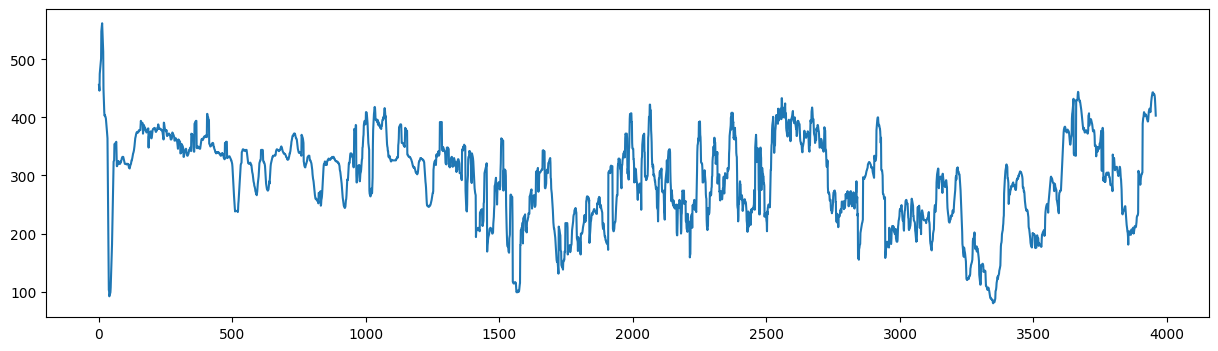

In [59]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["AQI"])
plt.show()

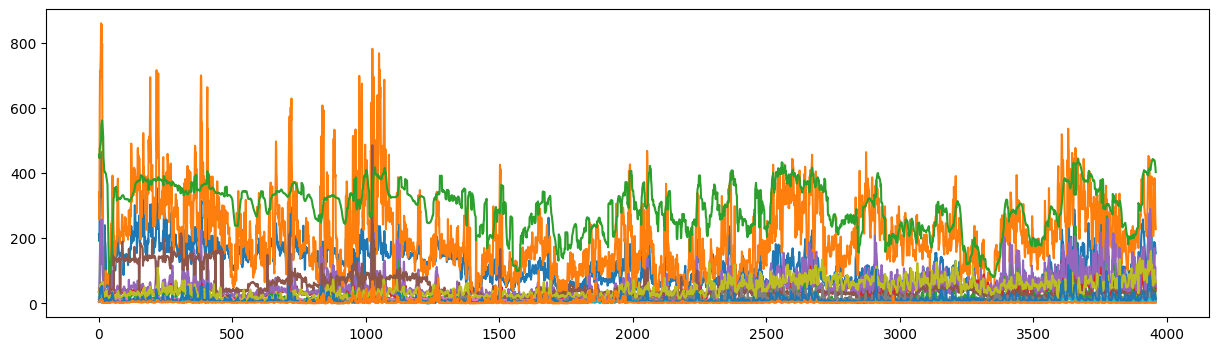

In [60]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [61]:
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [62]:
torch.manual_seed(42)

batch_size = 1
sequence_length = 3
target = "AQI"
features = ['PM2.5','PM10','CO','SO2', 'O3','Benzene','Toluene','Xylene','NO','NOx','NH3','NO2']

train_dataset = SequenceDataset(
    train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 12])
Target shape: torch.Size([1])


In [63]:
class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1
        
        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [64]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    
    total_loss = 0
    model.train()

    for X, y in data_loader:
        optimizer.zero_grad()
        model.zero_grad()
        output = model(X)
        #print(output)
        #print(y)
        loss = loss_function(output, y)

        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        

    avg_loss = total_loss / num_batches
    
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model.forward(X)
            #print(output)
            #print(y)
            total_loss += loss_function(output, y).item()
            
    avg_loss = total_loss / num_batches
    
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [65]:
learning_rate = 0.05
num_hidden_units = 16

Qmodel = QRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [66]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(5):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------


Test loss: 152486.03362136995
Execution time 79.14151883125305
Epoch 0
---------


KeyboardInterrupt: 

In [ ]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
            

    return output

In [ ]:

train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
ystar_col = "Model forecast"

train[ystar_col] = predict(train_eval_loader, model).numpy()
test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((train, test))[[target, ystar_col]]

# for c in df_out.columns:
#     df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x15 and 16x4)